In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import country_converter as coco
import yaml
from utilities import exposure_new, exposure_contour, read_ac_data, gdp_from_cdd_exposure, plot_gdp_increase_map, plot_gdp_increase_scatter

In [2]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
future_year = config["future_year"]

/tmp/ipykernel_2477811/3448971169.py:58: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


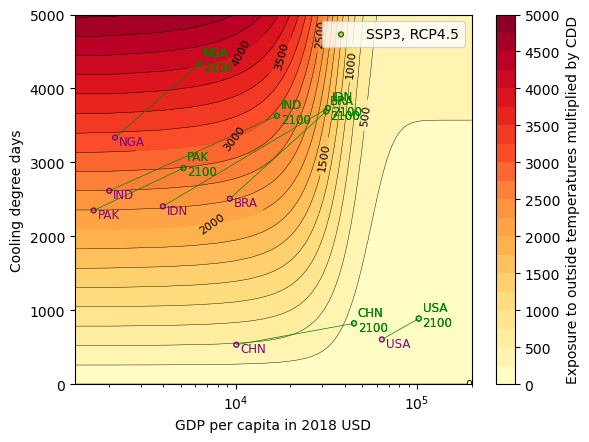

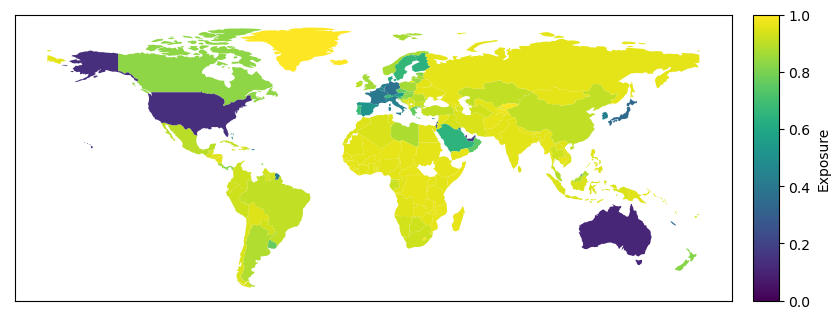

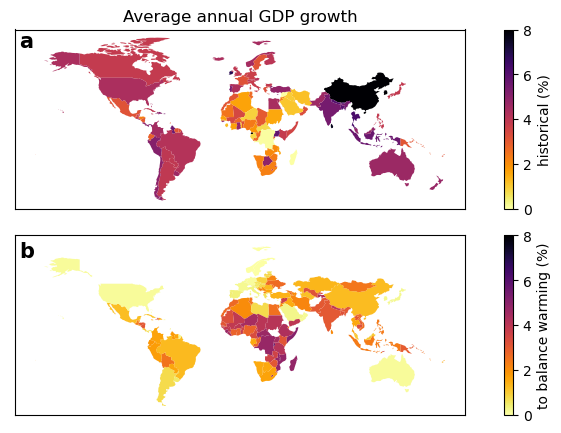

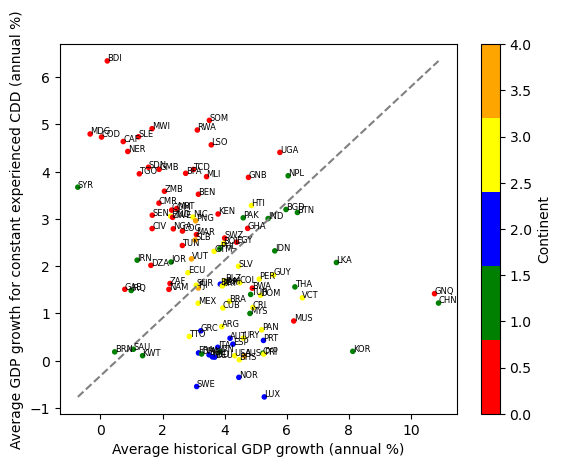

In [3]:
for ssp_rcp in ['3_45']:#, '5_60']:
    ssp = ssp_rcp.split('_')[0]
    rcp = ssp_rcp.split('_')[1]

    # Read in AC, GDP, DD data
    ac_data_historical = read_ac_data('data_experiencedT/AC_data.csv')

    # Add predictions for DD_mean and GDP for the countries in ac_data
    # Read in data for countries in ac_data
    dd_projection = pd.read_csv('data_experiencedT/projections/ISO_CDD_GDP18_agg_data.csv')
    # Filter for SSP and RCP
    dd_projection = dd_projection.loc[(dd_projection['rcp'] == 'rcp{0}'.format(rcp)) & (dd_projection['ssp'] == 'SSP{0}'.format(ssp)) & (dd_projection['year'] == future_year) & (dd_projection['stat'] == 'mean')]
    # Filter to keep countries in ac_data
    dd_projection = dd_projection[dd_projection['ISO'].isin(ac_data_historical['ISO3'])]
    # Rename ISO to ISO3
    dd_projection = dd_projection.rename(columns={'ISO': 'ISO3'})
    # Only keep ISO and value columns
    dd_projection = dd_projection[['ISO3', 'value']]
    # Rename value column to DD_mean
    dd_projection = dd_projection.rename(columns={'value': 'DD_mean'})
    dd_projection.set_index('ISO3', inplace=True)

    gdp_projection = pd.read_csv('data_experiencedT/projections/gdp_edu_projections.csv')
    # Filter for SSP and year 2100
    gdp_projection = gdp_projection.loc[(gdp_projection['scenario'] == 'SSP{0}'.format(ssp)) & (gdp_projection['year'] == future_year)]
    # Only keep countrycode and gdpcc columns
    gdp_projection = gdp_projection[['countrycode', 'gdppc']]
    # Only keep countries in ac_data
    gdp_projection = gdp_projection[gdp_projection['countrycode'].isin(ac_data_historical['ISO3'])]
    # Rename countrycode to ISO
    gdp_projection = gdp_projection.rename(columns={'countrycode': 'ISO3'})

    # Merge the two dataframes
    merged_projections = pd.merge(dd_projection, gdp_projection, on='ISO3')

    # Add _2100 to ISO3 column
    merged_projections['ISO3'] = merged_projections['ISO3'] + '_2100'
    # Rename gdppc to GDP
    merged_projections = merged_projections.rename(columns={'gdppc': 'GDP'})

    # Add to ac_data without append
    ac_data = pd.concat([ac_data_historical, merged_projections])
    ac_data = ac_data.reset_index(drop=True)

    # Contour data for exposure if value for AC is available if not _2100 is added to ISO3 and also the corresponding countries with _2100
    ac_data_contour = ac_data.copy()
    ac_data_countries = ac_data_contour['ISO3'].unique() + '_2100'
    ac_data_contour = pd.concat([ac_data_contour, ac_data[ac_data['ISO3'].isin(ac_data_countries)]])

    # Plot exposure contour
    exposure_contour(exposure_new, ac_data_contour, multiply_cdd=True, contour_lines=True,
                    name_tag='exposure_contour_ssp_{0}_rcp_{1}'.format(ssp, rcp), future_scenario='\nSSP {0}, RCP {1}'.format(ssp, int(rcp)/10))
    

    def plot_exposure_map(ac_data_historical):
        # Plot exposure map
        # Load world geometries
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        # Copy your data
        ac_data_map = ac_data_historical.copy()
        # Convert ISO3 codes in your data to match the world dataframe
        cc = coco.CountryConverter()
        ac_data_map['ISO3'] = cc.convert(names=ac_data_map['ISO3'].values.tolist(), to='ISO3', not_found=None)
        # Merge your data with the world geometries
        merged_data = ac_data_map.merge(world[['geometry', 'iso_a3']], left_on='ISO3', right_on='iso_a3', how='left')
        # Convert the merged data to a GeoDataFrame
        ac_data_map_geo = gpd.GeoDataFrame(merged_data, geometry='geometry')

        ac_data_map_geo['exposure_calculated'] = exposure_new(ac_data_map_geo['GDP'], ac_data_map_geo['DD_mean'])
        # Plot the data
        fig, ax = plt.subplots(figsize=(10, 5))
        # Plot the data
        ac_data_map_geo.plot(column='exposure_calculated', ax=ax, cmap='viridis', vmin=0, vmax=1)

        # Color bar same height as map
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3.5%", pad=0.1)
        plt.colorbar(ax.collections[0], cax=cax, label='Exposure')
        
        # Remove axes ticks
        ax.set_xticks([])
        ax.set_yticks([])

        plt.savefig('Figures/exposure_map.png', dpi=300)

        return ac_data_map_geo

    # Plot exposure map
    ac_data_map_geo = plot_exposure_map(ac_data_historical)


    # Compute change in experienced CDD compared to present (2018)    
    # Copy ac_data to ac_data_new and only keep ISO3, DD_mean and GDP columns
    ac_data_new = ac_data[['ISO3', 'DD_mean', 'GDP']].copy()
    # Add column for exposure times CDD
    ac_data_new['exposure_times_cdd'] = exposure_new(ac_data_new['GDP'], ac_data_new['DD_mean'])*ac_data_new['DD_mean']
    # Split dataset into two: One with ISO3 without _2100 and one with ISO3 with _2100
    ac_data_new_2100 = ac_data_new[ac_data_new['ISO3'].str.contains('_2100')]
    ac_data_new = ac_data_new[~ac_data_new['ISO3'].str.contains('_2100')]
    # Only keep the same countries
    ac_data_new = ac_data_new[ac_data_new['ISO3'].isin(ac_data_new_2100['ISO3'].str.replace('_2100', ''))]

    ac_data_new['diff_exposure_times_cdd'] = ac_data_new_2100['exposure_times_cdd'].values - ac_data_new['exposure_times_cdd'].values
    ac_data_new['diff_cdd'] = ac_data_new_2100['DD_mean'].values - ac_data_new['DD_mean'].values


    # Calculate GDP needed to keep exposure times CDD constant
    ac_data_new['gdp_const'] =  (gdp_from_cdd_exposure(ac_data_new['exposure_times_cdd'], ac_data_new_2100['DD_mean']) / ac_data_new['GDP']) ** (1./(future_year - 2018)) - 1. 

    ac_data_new = plot_gdp_increase_map(ac_data_new, ac_data_map_geo, ssp, rcp)
    plot_gdp_increase_scatter(ac_data_new, ssp, rcp)
